In [1]:
import gspread
from oauth2client.service_account import ServiceAccountCredentials
from googleapiclient.discovery import build

In [175]:
from matplotlib import pyplot as plt
import seaborn as sns
from pandas import DataFrame, option_context, to_datetime, read_csv, read_excel
import regex as re
from datetime import datetime, date
import numpy as np

In [3]:
# defining the scope of the application
scope_app = ['https://spreadsheets.google.com/feeds','https://www.googleapis.com/auth/drive'] 

#credentials to the account
cred = ServiceAccountCredentials.from_json_keyfile_name('baby-sleep-war-89c8dcb4a508.json',scope_app) 

# authorize the clientsheet 
client = gspread.authorize(cred)

In [4]:
def print_all(text):
    with option_context('display.max_rows', None, 'display.max_columns', None):  
        # more options can be specified also
        print(text)

In [5]:
spreadsheet_id = '1l-bLCA0f4gsYgnDE6aeoTM9nH5uuc48Z1zRw9uHTNjo'
range_name = 'A1:BA1300'
#sh = client.open('baby-sleep_war')

service = build('sheets', 'v4', credentials=cred)
result = service.spreadsheets().values().get(spreadsheetId=spreadsheet_id, range=range_name).execute()
answers = result.get('values', [])
print(f"{len(answers)} rows retrieved")

df_zero = DataFrame(answers[1:], columns=answers[0])
#print(df.info())

1236 rows retrieved


In [116]:
df = df_zero.copy()

col_names_en = {
    'Отметка времени': "time",
    'Адрес электронной почты':	"email",
    '1. У якому населеному пункті України ви проживали до 24 лютого 2022 року?':	"location_before",
    '2. Скільки зараз вашій (молодшій) дитині? Дата народження у форматі дд.мм.рррр ':	"birthday_younger",
    '3. Стать (молодшої) дитини':	"gender_younger",
    '4. Якщо у вас більше, ніж одна дитина, вкажіть вік (дати народження) старших дітей. \nЯкщо у вас тільки 1 дитина, поставте "-", будь ласка ':	"age_older",
    '5. Стать старшої дитини (дітей). Якщо у вас тільки 1 дитина, поставте "-"  ':	"gender_older",
    '6. Який тип вигодовування у вашої (молодшої) дитини?':	"feeding",
    '7. Чи є особливості стану здоров’я дитини, на які ви звертали увагу до 24 лютого? ':	"health",
    '8. Як ви б оцінили сон вашої дитини до 24 лютого? (від 1 до 5, де 1 – жахливий сон, 5 – чудовий сон)? ':	"kidsleep_grade_before",
    '9. Як, на вашу думку, змінився сон вашої дитини у перший місяць повномасштабної війни від 24 лютого 2022 року? ':	"kidsleep_dynamics",
    '10. Чи працювали ви над сном дитини до 24 лютого 2022 року?':	"sleep_experience",
    '11. Чи залишали ви ваше місце проживання разом з дітьми після 24 лютого? ':	"leave_home",
    "12. Якщо у попередньому питанні ви відповіли так, у який день ви це зробили? Якщо ви точно не пам'ятаєте дату, вкажіть приблизний день ":	"when_leave_home",
    '13. Чому ви прийняли рішення це зробити? (Якщо ви не залишали місце проживання, залиште "-" у відповідь на це питання) ':	"why_leave_home",
    '14. Яким транспортом ви здійснювали переїзд? ':	"transport_lh",
    '15. Скільки годин тривала ваша дорога до нового місця проживання? (цифра, годин) ':	"lh_duration",
    '16. Як був організований сон дитини під час дороги? ':	"kidsleep_lh",
    '17. У яку локацію ви змушені були переїхати? ':	"new_location",
    '18. Чи був у вас досвід перебування з дитиною у бомбосховищі/підвалі? ':	"shelter_experience",
    '19. Чи був у вас досвід сну з дитиною у бомбосховищі/підвалі? ':	"shelter_kidsleep",
    '20. Як було у сховищі організоване місце для сну дитини? ':	"shelter_organisation",
    '21. Чи доводилося вам вкладати спати дитину у верхньому одязі? ':	"outerwear_kidsleep",
    '22. Чи доводилося вам вкладати спати дитину при низькій температурі в приміщенні? ':	"coldroom_kidsleep",
    '23. Чи довелося вам знаходитися у ситуації з обмеженим доступом до питної води? ':	"lack_water",
    '24. Скільки днів ви знаходилися у ситуації обмеженого доступу до води? ':	"lack_water_duration",
    '25. Чи довелося вам знаходитися у ситуації з обмеженим доступом до продуктів харчування? ':	"lack_food",
    '26. Чи був у вас досвід перебування з дитиною без електроенергії? ':	"lack_elecricity",
    '27. Чи довелося вам розлучити дитину з рідними, звичним оточенням? ':	"kid_separation",
    '28. Чи був у вас досвід вкладання дитини у коридорі квартири/будинку «за правилом двох стін»? ':	"2walls",
    '29. Як було організоване спальне місце дитини у коридорі?':	"2walls_sleeporganization",
    '30. Як ви вкладали дитину до 24 лютого? ':	"sleep_method_before",
    '31. Чи змінився ваш спосіб вкладання дитини після 24 лютого? ':	"sleep_method_change",
    '32. Як змінилося ваше вкладання дитини у лютому-березні? ':	"sleep_method_after",
    '33. Чи змінилась кількість нічних пробуджень дитини у лютому-березні? ':	"night_wakings_after",
    '34. Як вкладається ваша дитина зараз, у серпні-вересні? ':	"sleep_method_now",
    '35. Чи прокидається ваша дитина чи ви вночі під час сирени повітряної тривоги?':	"siren_wakeup",
    '36. Чи змінився ваш сон у лютому-березні? Опишіть, будь ласка, як ви спали у перші дні війни разом із малюком, і як вам вдавалося поспати, і чи вдавалося це. ':	"momsleep_war",
    '37. Чи відрізняється ваш сон зараз від того, як ви спали у лютому-березні? ':	"momsleep_now",
    '38. Чи змінили ви зараз локацію свого проживання порівняно з лютим-березнем 2022 року? ':	"location_now",
    '39. Розкажіть, будь ласка, свою історію – як ви з дитиною переживали всі події з 24 лютого. Можливо, ви хотіли б доповнити свої відповіді на питання, з урахуванням того, що не було представлено у цій анкеті. ':	"story_war",
    '40. Чого вам не вистачало у перші місяці після 24 лютого? ':	"defficiency",
    '41. Ваша стать':	"gender",
    '42. Скільки вам повних років? (Вкажіть, будь ласка, цифру)':	"age",
    '43. Ваша освіта':	"education",
    '44. Дохід вашої родини відносно інших громадян України ви можете оцінити як:':	"income_level",
    '45. Який зараз статус ваших стосунків':	"relationship",
    '46. Чи є у вас питання, на які б ви хотіли отримати відповіді від мене? ':	"questions",
    '47. Що, на вашу думку, могло б вас зараз підтримати? ':	"support",
    '48. Чи є якесь повідомлення, яке б ви хотіли передати міжнародній спільноті, якій я буду розповідати про те, як зараз українські батьки переживають важкі події разом з малюком? ':	"message",
    '49. Я погоджуюся на анонімне публічне цитування своїх розширених відповідей на деякі питання цієї анкети ':	"quote",
    '50. Я даю дозвіл на обробку даних із цієї анкети для подальшого аналізу та публікації результатів':	"informed_consent",
    '51. Чи бажаєте ви отримати результати дослідження чи відповіді на ваші запитання на вашу електронну пошту?': "feedback"}

df.rename(columns=col_names_en, inplace=True)
df.columns

Index(['time', 'email', 'location_before', 'birthday_younger',
       'gender_younger', 'age_older', 'gender_older', 'feeding', 'health',
       'kidsleep_grade_before', 'kidsleep_dynamics', 'sleep_experience',
       'leave_home', 'when_leave_home', 'why_leave_home', 'transport_lh',
       'lh_duration', 'kidsleep_lh', 'new_location', 'shelter_experience',
       'shelter_kidsleep', 'shelter_organisation', 'outerwear_kidsleep',
       'coldroom_kidsleep', 'lack_water', 'lack_water_duration', 'lack_food',
       'lack_elecricity', 'kid_separation', '2walls',
       '2walls_sleeporganization', 'sleep_method_before',
       'sleep_method_change', 'sleep_method_after', 'night_wakings_after',
       'sleep_method_now', 'siren_wakeup', 'momsleep_war', 'momsleep_now',
       'location_now', 'story_war', 'defficiency', 'gender', 'age',
       'education', 'income_level', 'relationship', 'questions', 'support',
       'message', 'quote', 'informed_consent', 'feedback'],
      dtype='object')

In [266]:
city = df.location_before
city = city.replace(['М\.','М\. ','м\.', '^м\.', ' м ', ',м'], ' ', regex=True)
city = city.str.strip()
print_all(city.sort_values())
#df[df['city'] == 'мбровари']

441                                                 irpin
520                                                 бабаї
588                                               бабинці
170                           балаклія, харківськаобласть
916                                              баштанка
796                                              бердичів
1085                                            бердянськ
969                                             бердянськ
93                                              бердянськ
751                        берегове, закарпатська область
624                                              бережани
1104                    бережани , тернопільській області
134                             бобриця, бучанський район
621                            богуслав київської області
756                                             бориспіль
1205                                            бориспіль
517                                             бориспіль
255           

In [287]:
df_corrections = read_excel('../data/settlements_of_Ukraine.xlsx', sheet_name='corrections_cities')
df_corrections.initial = df_corrections.initial.str.lower()
df_corrections.corrected = df_corrections.corrected.str.lower()
#print(df_corrections.columns)
dic_corrections = df_corrections.loc[~df_corrections.corrected.isna()].set_index('initial')['corrected'].to_dict()
#dic_corrections

In [290]:
# TODO: write to function

dic_place = {'село':'',
        'с. ':'',
        'пп':'',
        'смт. ':'',
        'смт ':''}

dic_region = {
        'київська область': '',
        'київська обл':'',
        'київської обл':'',
        'київської області':'',
        'волинська обл':'',
        'вінницька обл':'',
        'дніпропетровська обл':'',
        'дніпоопетровська обл':'',
        'дніпроопетровская обл':'',
        'дніпропетровської області':'',
        '(дніпропетровська)':'',
        'дніпроопетровская обл':'',
        'донецька обл':'',
        'житомирська обл':'',
        'житомирської області':'',
        'закарпатська обл':'',
        'кіровоградська обл':'',
        'львівської обл':'',
        'львівська обл':'',
        'львівської області':'',
        'луганська обл':'',
        'івано-франківська обл':'',
        'миколаївська обл':'',
        'одеська обл':'',
        'рівненська обл':'',
        ', полтавська область': '',
        'полтавська обл':'',
        'сумська обл':'',
        'тернопільська обл':'',
        'тернопільській області':'',
        'харківськаобл':'',
        'харківська обл':',',
        'харківський район':'',
        'харківський рн':'',
        'харкіскьска обл ':'',
        'херсонська обл':'',
        'чернігівська обл':'',
        'чернівецька обл':'',
        'черкаська обл':'',
        'фастівська обл':'',
        'київ1':'київ',
        'київґ':'київ',
        'киів':'київ',
        'м.київ':'київ',
        'киев':'київ',
        'ирпень': 'ірпінь',
        'irpin': 'ірпінь',
        'днепр':'дніпро',
        'харьков':'харків',
        'герой харків':'харків',
        'харьків':'харків',
        'харів':'харків',
        'харько':'харків',
        'кременчуці':'кременчук',
        'коеменчук':'кременчук',
        'кременчуг':'кременчук',
        'івано-франківську':'івано-франківськ',
        'запорожье':'запоріжжя',
        'одесса':'одеса'
        }

df.location_before = df.location_before.str.lower()
df.location_before = df.location_before.str.strip()
df.location_before = df.location_before.replace(dic_corrections, regex=True)

city = df.location_before
city = city.replace(['м\.', '^м\.', ' м ', ',м', 'місто'], '', regex=True)
city = city.replace(['область','облачть', 'області'], 'обл', regex=True)
city = city.replace(dic_place, regex=True)
city = city.str.strip()
city = city.replace(dic_region, regex=True)
city = city.str.replace('[^\w\s]','', regex=True)
city = city.str.strip()
city = city.replace(['івано франківськ', 'іванофранківськ', 'івано  франківськ'], 'іванофранківськ', regex=True)
city = city.replace('харків північна салтівка', 'харків')
city = city.replace('кропивницький кіровоград', "кропивницький") 
#city = city.replace('камянецьподільський', "кам'янець-подільський")
print('Кількість населених пунктів серед респондентів:', len(city.unique()))

df_city = city.value_counts()
print_all(df_city.sort_values())
"""
print_all(df[['city_raw', 'city']])
"""
df['city'] = city

#df[['city_raw', 'city']].to_csv(r'city.csv', index = False)
#df[['city_raw', 'city']][df['city']=='']


Кількість населених пунктів серед респондентів: 179
білогородка                   1
рудно                         1
золотоноша                    1
коротич                       1
добротвір                     1
ворзель                       1
корець                        1
лебедівка                     1
бубнівська слобідка           1
лохвиця                       1
вугледар                      1
снятин                        1
світловодськ                  1
павлиш                        1
страдч                        1
макарів                       1
камянобрід                    1
овруч                         1
покровськ                     1
гатне                         1
здвижівка                     1
софіївка                      1
баштанка                      1
пятихатки                     1
мощун                         1
бердичів                      1
северинівка                   1
бузова                        1
святогірськ                   1
трепівка            

In [285]:
df_regions = read_excel('../data/settlements_of_Ukraine.xlsx', sheet_name='places')
df_regions['village'] = df_regions['village'].str.lower()
df_regions['region'] = df_regions['region'].str.lower()
df_regions['village'] = df_regions['village'].str.replace('[^\w\s]','', regex=True)
dic_regions = df_regions.set_index('village')['region'].to_dict()
#dic_regions = {k.lower():v.lower() for k,v in dic_regions.items()}
dic_regions

{'вінниця': 'вінницька',
 'луцьк': 'волинська',
 'дніпро': 'дніпропетровська',
 'донецьк': 'донецька',
 'житомир': 'житомирська',
 'ужгород': 'закарпатська',
 'запоріжжя': 'чернігівська',
 'іванофранківськ': 'івано-франківська',
 'київ': 'київська',
 'кропивницький': 'кіровоградська',
 'луганськ': 'луганська',
 'львів': 'львівська',
 'миколаїв': 'чернігівська',
 'одеса': 'одеська',
 'полтава': 'харківська',
 'рівне': 'чернівецька',
 'суми': 'сумська',
 'тернопіль': 'тернопільська',
 'харків': 'харківська',
 'херсон': 'херсонська',
 'хмельницький': 'хмельницька',
 'черкаси': 'львівська',
 'чернівці': 'вінницька',
 'чернігів': 'чернігівська',
 'адамівка': 'чернігівська',
 'антонівка': 'чернігівська',
 'балки': 'хмельницька',
 'бар': 'львівська',
 'бар селище войнашівська сільська рада': 'вінницька',
 'барок': 'вінницька',
 'біличин': 'вінницька',
 'борщі': 'одеська',
 'бригідівка': 'вінницька',
 'буцні': 'хмельницька',
 'васютинці': 'черкаська',
 'верешки': 'вінницька',
 'верхівка': 'зап

In [262]:
print_all(df[['location_before', 'city']])

                                        location_before  \
0                                                  київ   
1                                                  київ   
2                                                  київ   
3                                                  київ   
4                                                  київ   
5                                             тернопіль   
6                                                  київ   
7                                               харків    
8                                                 одеса   
9                                           м. полтава    
10                                                харів   
11                                               харків   
12                                                 київ   
13                                            чернівці    
14                                                 київ   
15                                             миколаїв 

In [ ]:
dic_regions

In [276]:
#df.location_before = df['location_before'].str.lower()
df['region'] = df.location_before.str.extract('(\w+(?=\s+обл))', flags=re.IGNORECASE)
df['region'].loc[df['region'].isnull()] = df['city'].replace(dic_regions, method='bfil')

In [280]:
print_all(df['region'].value_counts())
print_all(df[['region']].loc[df['city'] == df['region']])

київська                    395
харківська                  272
львівська                   116
дніпропетровська             71
чернігівська                 57
одеська                      46
полтавська                   36
вінницька                    27
житомирська                  25
хмельницька                  22
херсонська                   20
івано-франківська            18
чернівецька                  14
сумська                      14
тернопільська                12
кіровоградська               10
донецька                      8
волинська                     7
камянське                     6
рівненська                    5
запорізька                    5
черкаська                     5
закарпатська                  4
сєвєродонецьк                 4
луганська                     3
миколаївська                  2
                              2
хмельницкий                   2
слобожанське                  2
франківська                   2
немішаєво                     2
київсько

Replace "Дитина народилася після 24 лютого" with 0 and cast column to int

In [70]:
df['kidsleep_grade_before'] = df['kidsleep_grade_before'].replace('Дитина народилася після 24 лютого', 0)
df['kidsleep_grade_before'] = df['kidsleep_grade_before'].astype('int')
df['kidsleep_grade_before'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 1235 entries, 0 to 1234
Series name: kidsleep_grade_before
Non-Null Count  Dtype
--------------  -----
1235 non-null   int32
dtypes: int32(1)
memory usage: 4.9 KB


Plot distribution of quality of sleep before the war

   unique_values    counts
0              4  0.449393
1              5  0.321457
2              3  0.176518
3              2  0.029150
4              0  0.016194
5              1  0.007287


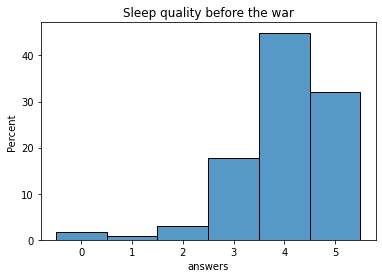

In [71]:
# sleep before the war
# TODO: sort

df_qual = df['kidsleep_grade_before'].value_counts(normalize=True).rename_axis('unique_values').reset_index(name='counts')
#print('Distribution of sleep quality before the war in %:\n{}'.format(df["8. Як ви б оцінили сон вашої дитини до 24 лютого? (від 1 до 5, де 1 – жахливий сон, 5 – чудовий сон)? "].value_counts(normalize=True)*100))
print(df_qual)
sns.histplot(
        x=df['kidsleep_grade_before'].sort_values(),
        stat="percent", 
        discrete=True
        ).set(title='Sleep quality before the war',
                xlabel='answers')
plt.show()

## Age of children

In [48]:
print_all(df.birthday_younger)

0                                           02/08/2016
1                                           07/03/2011
2                                           15/07/2005
3                                           04/11/2016
4                                           23/07/2021
5                                           22/05/2020
6                                           09/03/2021
7                                           02/11/2020
8                                           04/12/2013
9                                           03/06/2021
10                                          20/08/2019
11                                          25/12/2016
12                                          17/10/2017
13                                          29/04/2021
14                                          26/12/2021
15                                          25/09/2020
16                                          11/07/2018
17                                          21/02/2020
18        

In [44]:
# change . and , into "/"

df['birthday_younger'] = df['birthday_younger'].replace(['\.',','],'/', regex=True)
#df['birthday_younger'] = df['birthday_younger'].replace(',','/', regex=True)

In [45]:
# find rows with a short year (2 digits) and add 20 before the number of the year

df['birthDate_yearShort'] = df['birthday_younger'].apply(lambda x: re.search('\d{1,2}/\d{2}/\d{2}$', x))
df['birthDate_yearShort'] = df['birthDate_yearShort'].apply(lambda x: x.group() if x else x)
#print(df[['birthday_younger','birthDate_yearShort']][df['birthDate_yearShort'].notnull()])

def insert_string_middle(str, word):
    """
    insert the string word in middle of the string, 2 characters before the end
    """
    return str[:-2] + word + str[-2:]

# apply the function for all rows, where the year only has 2 digits

df['birthDate_yearShort'] = df['birthDate_yearShort'][df['birthDate_yearShort'].notnull()].apply(lambda x: insert_string_middle(x, '20'))
#print(df[['birthday_younger','birthDate_yearShort']][df['birthDate_yearShort'].notnull()])
df['birthday_younger'].loc[df['birthDate_yearShort'].notnull()] = df['birthDate_yearShort']


In [ ]:
#print(df[['birthday_younger','birthDate_yearShort']][df['birthDate_yearShort'].notnull()])

In [47]:
# look for dates with one digit day, add a leading zero. only looking for dates with 4 digit year

df['birthDate_short'] = df['birthday_younger'].apply(lambda x: re.search('^\d{1,2}/\d{2}/\d{4}', x))
df['birthDate_short'] = df['birthDate_short'].apply(lambda x: x.group() if x else x)

# fill in the date with leading 0 until it's 10 digits long (should be carried out after all years are 4 digits long)
df['birthDate_short'] = df['birthDate_short'].str.zfill(10)
#print_all(df[['birthday_younger','birthDate_short']][df.birthDate_short.notnull()])
df['birthday_younger'].loc[df.birthDate_short.notnull()] = df['birthDate_short']
#print_all(df[['birthday_younger','birthDate_short']][df.birthDate_short.notnull()])

In [49]:
def try_parsing_date(text):
    for fmt in ('%Y-%m-%d', '%d.%m.%Y', '%d/%m/%Y'):
        try:
            return datetime.strptime(text, fmt)
        except ValueError:
            pass
    raise ValueError('no valid date format found')

def age(birthdate, countDate=None):
    """
    returns the float with a full number of years between birthdate and countDate. 
    if countDate is not given, takes todays date
    """
    today = date.today()
    if countDate == None:
        countDate = today
    birthdate = to_datetime(birthdate)
    age = countDate.year - birthdate.year - ((countDate.month, countDate.day) < (birthdate.month, birthdate.day))
    return int(age)

df['birthDate'] = df['birthday_younger'].apply(lambda x: re.search('\d{2}/\d{2}/\d{4}', x))
df['birthDate'] = to_datetime(df['birthDate'].apply(lambda x: x.group() if x else x), format='%d/%m/%Y', dayfirst=True, errors='coerce') #format='%d-%m-%Y',

# calculate age with the function age. Age is calculated on the moment of closing the questionnaire (24.09.2022)
closingDate = datetime(2022, 9, 24)
df['age_younger'] = df['birthDate'][df['birthDate'].notnull()].apply(lambda x: age(x, closingDate))

In [ ]:
df['birthday_younger']

In [50]:
#print_all(df[['birthday_younger','birthDate2', 'age_younger']])

print(f'{df.age_younger.isnull().sum()} birth dates could not be processed:')
print_all( df[['birthday_younger', 'birthDate']][df.age_younger.isnull()])
print(f"{len(df[df['age_younger']<0])} have age under 0:")
print_all(df[['birthday_younger', 'birthDate', 'age_younger']][df['age_younger'] < 0])
print(f"{len(df[df['age_younger'] > 18])} have age over 18:")
print_all(df[['birthday_younger', 'birthDate', 'age_younger']][df['age_younger'] > 18])

38 birth dates could not be processed:
                  birthday_younger birthDate
27                               8       NaT
34                             5/8       NaT
45                           1 рік       NaT
59                         5 років       NaT
60                    Серпень 2017       NaT
78                               6       NaT
139                        2 роки        NaT
192                        6 років       NaT
194                         5років       NaT
274                    8/5 місяців       NaT
284                              7       NaT
306                          2/5 р       NaT
309                              9       NaT
354                       6 років        NaT
405                             10       NaT
411                        6 років       NaT
427                              5       NaT
483                     02/92/3015       NaT
552                       1/7 роки       NaT
553                          1 рік       NaT
595             

Plot children age distribution based on age_younger column

    unique_values    counts
0             1.0  0.214703
1             2.0  0.163743
2             0.0  0.131161
3             3.0  0.118630
4             4.0  0.092732
5             5.0  0.073517
6             6.0  0.053467
7             7.0  0.044277
8             8.0  0.030075
9             9.0  0.028404
10           10.0  0.012531
11           11.0  0.008354
12           -1.0  0.008354
13           12.0  0.006683
14           13.0  0.005013
15           17.0  0.002506
16           14.0  0.001671
17           15.0  0.000835
18           -8.0  0.000835
19           -5.0  0.000835
20           16.0  0.000835
21           31.0  0.000835


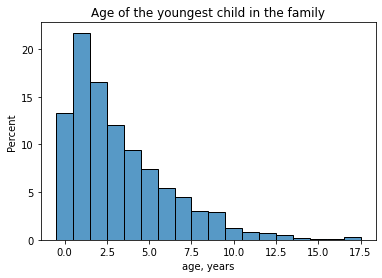

In [84]:
df_age_count = df['age_younger'].value_counts(normalize=True).rename_axis('unique_values').reset_index(name='counts')
#print('Distribution of sleep quality before the war in %:\n{}'.format(df["8. Як ви б оцінили сон вашої дитини до 24 лютого? (від 1 до 5, де 1 – жахливий сон, 5 – чудовий сон)? "].value_counts(normalize=True)*100))
print(df_age_count)
img = sns.histplot(
        x=df['age_younger'][(df['age_younger']>=0) & (df['age_younger'] <= 18)].sort_values(),
        stat="percent", 
        discrete=True
        ).set(title='Age of the youngest child in the family',
                xlabel='age, years')
#img.set_xticks(range(18))

plt.show()

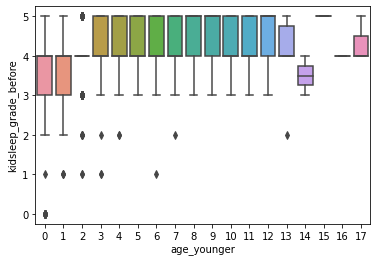

In [85]:
df_age = df[['age_younger', 'kidsleep_grade_before']][df['age_younger']>=0].dropna()
df_age = df_age[df_age['age_younger'] <= 18]
df_age['age_younger'] = df_age['age_younger'].astype('int')

sns.boxplot(data=df_age, x='age_younger', y='kidsleep_grade_before')
plt.show()

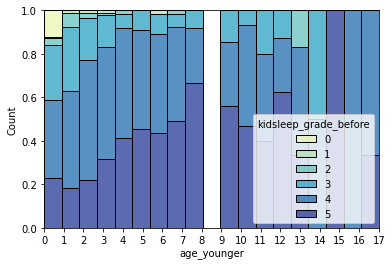

In [96]:
palette = sns.color_palette('YlGnBu')
img = sns.histplot(data=df_age,
                x='age_younger', 
                multiple='fill', 
                hue='kidsleep_grade_before',
                bins=19,
                palette=palette)
img = img.set_xticks(range(18))

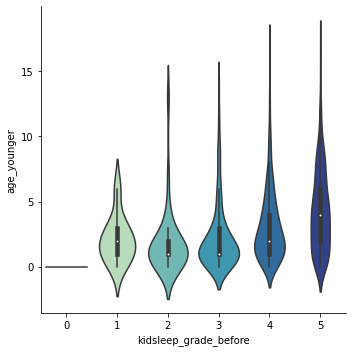

In [94]:
sns.catplot(data=df_age, 
            y='age_younger', 
            x="kidsleep_grade_before", 
            kind='violin',
            palette=palette)
plt.show()

In [157]:
df_age[['age_younger', 'kidsleep_grade_before']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1184 entries, 0 to 1234
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   age_younger            1184 non-null   float64
 1   kidsleep_grade_before  1184 non-null   int32  
dtypes: float64(1), int32(1)
memory usage: 23.1 KB


In [17]:
df['gender_younger'].value_counts()

female                         623
male                           595
Двійня - дві дівчинки            7
Двійня - хлопчик і дівчинка      6
Двійня - два хлопчики            3
Одна дитина                      1
Name: gender_younger, dtype: int64

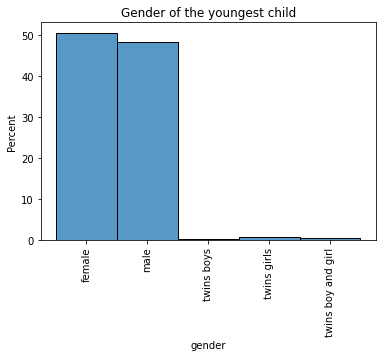

In [20]:
dic_gender = {'Дівчинка': 'female', 
            'Хлопчик':'male', 
            'Двійня - два хлопчики':'twins boys', 
            'Двійня - дві дівчинки': 'twins girls', 
            'Двійня - хлопчик і дівчинка': 'twins boy and girl', 
            'Одна дитина ': np.NAN}
df['gender_younger'] = df['gender_younger'].replace(dic_gender).dropna()
sns.histplot(df['gender_younger'],
            stat="percent", 
            discrete=True
            ).set(title='Gender of the youngest child',
            xlabel='gender'
            )
plt.xticks(rotation=90)
plt.show()

In [82]:
# TODO: discuss, if ok for the first analysis to have just yes/no
# TODO: if "no + something" - cut the rest after no

#df['health'].value_counts()
df['health'] = df['health'].str.lower()
df.health = df['health'].str.strip()
dic_healthState = {'-':'ні',
                    '"-"':'ні',
                    'немає':'ні',
                    'не має':'ні',
                    'нема':'ні',
                    'нет':'ні',
                    'не було':'ні',
                    'ні немає':'ні',
                    'ні. все добре':'ні',
                    'не було особливостей':'ні',
                    'ni':'ні',
                    'да': 'так'}
df.health = df.health.replace(dic_healthState)

health_dic = {'ні': 0,
                'так': 1}
df['health_short'] = df['health'].replace(health_dic)
df['health_short'].loc[~df['health_short'].isin([0, 1])] = 1
df['health_short'].value_counts()


C:\Users\afedorova\AppData\Local\Temp\ipykernel_23444\3118174790.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['health_short'].loc[~df['health_short'].isin([0, 1])] = 1


0    918
1    317
Name: health_short, dtype: int64

In [22]:
print('особливості стану здоров’я дитини до 24 лютого:')
print_all(df.health.value_counts())

особливості стану здоров’я дитини до 24 лютого:
ні                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

In [181]:
print('залишали місце проживання разом з дітьми\n',
        df['leave_home'].value_counts(normalize=True),
        sep='')

залишали місце проживання разом з дітьми
Так    0.820243
Ні     0.179757
Name: leave_home, dtype: float64


In [182]:
print('Чи змінилась кількість нічних пробуджень дитини\n',
    df['night_wakings_after'].value_counts(normalize=True))

Чи змінилась кількість нічних пробуджень дитини
 Так, дещо погіршилася ситуація вночі        0.573279
Ні                                          0.302024
Я не звертала уваги на нічні пробудження    0.086640
Так, дещо покращилася ситуація вночі        0.038057
Name: night_wakings_after, dtype: float64


In [183]:
df['lh_duration']

0                                                       2
1                    7 годин при звичному часі в 2 години
2                                                   7 діб
3                                                 7 годин
4                                                4.5-5год
                              ...                        
1230    Більше доби по Україні. Потім доба у родичів і...
1231                                                    2
1232                                                   96
1233                                             19 годин
1234                                                2 дні
Name: lh_duration, Length: 1235, dtype: object

In [72]:
#print_all(df['momsleep_war'].value_counts(normalize=True))
df['momsleep_war_short'] = df['momsleep_war'].str.lower()
df['momsleep_war_short'].loc[df['momsleep_war_short'].str.contains('не спала', case=False)] = 'так'
df['momsleep_war_short'] = df['momsleep_war_short'].replace('не змінився', 'ні', regex=True)
#df['momsleep_war_short'] = df['momsleep_war_short'].replace('Так', 'так', regex=True)
print_all(df['momsleep_war_short'].value_counts(normalize=True))

так                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  0.211336
ні                                                                                                                                                                                                                                                                                                                                                                                                        

C:\Users\afedorova\AppData\Local\Temp\ipykernel_23444\1958524728.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['momsleep_war_short'].loc[df['momsleep_war_short'].str.contains('не спала', case=False)] = 'так'


In [73]:
print_all(df['momsleep_war_short'].value_counts())

так                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  261
ні                                                                                                                                                                                                                                                                                                                                                                                                             

In [ ]:
#df['momsleep_war'].loc[df['momsleep_war'] == '-']
print_all(df.loc[df['momsleep_now'].str.contains('так|Покращився|краще', case=False), 'momsleep_now'])
df['momsleep_now_short'].loc[df['momsleep_now'].str.contains('так|Покращився|краще', case=False), 'momsleep_now'] = 'так'


In [65]:
df['momsleep_now_short'] = df['momsleep_now']
df['momsleep_now_short'] = df['momsleep_now_short'].str.strip().replace('/.', '')
df['momsleep_now_short'] = df['momsleep_now_short'].replace(['Ні', 'ні', 'Майже ні', 'Нет'], 'ні', regex=True)
df['momsleep_now_short'] = df['momsleep_now_short'].replace('Да', 'так', regex=True)
df['momsleep_now_short'].loc[df['momsleep_now_short'].str.contains('так|Покращився|краще', case=False)] = 'так'
print_all(df['momsleep_now_short'].value_counts())

так                                                                                                                                                                                                                                                                                                                                                                                             825
ні                                                                                                                                                                                                                                                                                                                                                                                               73
-                                                                                                                                                                                                                               

C:\Users\afedorova\AppData\Local\Temp\ipykernel_23444\3333467077.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['momsleep_now_short'].loc[df['momsleep_now_short'].str.contains('так|Покращився|краще', case=False)] = 'так'


In [185]:
print('Experience of going to the bomb shelter or cellar with the child')
df['shelter_experience'].value_counts(normalize=True)

Experience of going to the bomb shelter or cellar with the child


Ні                    0.349798
Так, понад 6 разів    0.319028
Так, 1-2 рази         0.204049
Так, 3-5 разів        0.127126
Name: shelter_experience, dtype: float64

In [186]:
print('Experience of the child sleeping in the bomb shelter or cellar')
df['shelter_kidsleep'].value_counts(normalize=True)

Experience of the child sleeping in the bomb shelter or cellar


Так                                                  0.415385
Ні, ми не були і сховищі з дитиною                   0.354656
Ні, ми були там з дитиною тільки під час неспання    0.229960
Name: shelter_kidsleep, dtype: float64

In [36]:
df.sleep_method_change.value_counts(normalize=True)

Ні                                                                                                                                                                                                                                                  0.586235
Так                                                                                                                                                                                                                                                 0.362753
-                                                                                                                                                                                                                                                   0.006478
Після повернення додому - ні. За коридором - так                                                                                                                                                                                                 

In [74]:
df.loc[(df['shelter_experience'] != 'Ні') & (df['shelter_kidsleep'] == 'Ні, ми не були і сховищі з дитиною')]

,time,email,location_before,birthday_younger,gender_younger,age_older,gender_older,feeding,health,kidsleep_grade_before,...,informed_consent,feedback,city_raw,city,birthDate_yearShort,birthDate_short,birthDate,age_younger,momsleep_war_short,momsleep_now_short
129,23.08.2022 22:47:37,oaplume@gmail.com,Дніпро,05/02/2021,Дівчинка,6 років,Дівчина,Грудне вигодовування + прикорм,-,2,...,Так,"Так, відповіді і результати дослідження",дніпро,дніпро,NaN,05/02/2021,2021-02-05,1.0,"сон пропав, інколи просто відключалася від втоми",так
186,24.08.2022 6:53:22,lukianovaolena@gmail.com,Харків,25/05/2020,Хлопчик,-,-,Вже перейшли на дорослу їжу,Ні,4,...,Так,"Так, відповіді і результати дослідження",харків,харків,NaN,25/05/2020,2020-05-25,2.0,так,так
375,25.08.2022 11:47:45,n.samarets1983@gmail.com,Харьков,17/03/2015,Дівчинка,-,-,Вже перейшли на дорослу їжу,Не має,4,...,Так,Ні,харьков,харків,NaN,17/03/2015,2015-03-17,7.0,"не мала змоги спати, пару годин коли дуже втом...",Не можу довго заснути
415,25.08.2022 13:56:17,gory4ka@gmail.com,Київ,09/02/2017,Дівчинка,-,-,Вже перейшли на дорослу їжу,Ні,5,...,Так,"Так, відповіді і результати дослідження",київ,київ,NaN,09/02/2017,2017-02-09,5.0,"донька засинала ,а я чергувала тривоги,поітм в...",так
601,26.08.2022 15:01:13,didukolia2111@gmail.com,Львів,31/08/2015,Дівчинка,-,-,Вже перейшли на дорослу їжу,Ні,3,...,Так,"Так, тільки результати дослідження",львів,львів,NaN,31/08/2015,2015-08-31,7.0,погано сплю,так
819,31.08.2022 9:20:47,rybalka.2344@gmail.com,Запоріжжя,01/09/2012,Дівчинка,-,-,Грудне вигодовування,Ні,5,...,Так,"Так, відповіді і результати дослідження",запоріжжя,запоріжжя,NaN,01/09/2012,2012-09-01,10.0,"так, прокидаюсь від маленького шуму",ні
867,06.09.2022 14:11:45,anna.gribinukova@gmail.com,Киів,2/5 на момент 24 лютого 2022,Хлопчик,-,-,Вже перейшли на дорослу їжу,Зуби та зір,5,...,Так,"Так, відповіді і результати дослідження",киів,київ,NaN,None,NaT,NaN,я дуже важко спала. дитина трошки гірше ніж за...,так
1083,07.09.2022 21:39:54,sashazvzvzv@gmail.com,Дніпро,02/05/2021,Дівчинка,-,-,Вже перейшли на дорослу їжу,Ні,2,...,Так,"Так, відповіді і результати дослідження",дніпро,дніпро,NaN,02/05/2021,2021-05-02,1.0,"сон став дуже чуттєвий.я часто прокидалась ,що...",так


In [77]:
df.age.value_counts()

33                         112
34                         109
30                         103
35                          94
32                          93
36                          83
31                          80
29                          69
28                          59
37                          55
38                          54
27                          50
26                          42
39                          36
40                          29
41                          25
25                          24
24                          18
42                          16
43                          14
22                          10
44                          10
23                          10
46                           8
45                           6
47                           5
20                           3
49                           2
33 роки                      2
16.07.1995                   1
26.02.1978                   1
01.01.1985                   1
42 роки 